## Preliminary Modelling
Start with simple (single-output) modelling methods
1. Linear regression single output
2. Linear regression **multi** output
3. Random forest regression single output
4. Multi-layer perceptron regression single output
5. Multi-layer perceptron regression **multi** output

In [221]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn import datasets, linear_model, metrics
import matplotlib.pyplot as plt
import numpy as np

## Load Data

In [274]:
# Load the raw data
df_all = pd.read_csv('data/220306_slugs_dataset.csv')
df_inp = df_all.drop(['loadCase', 'out_supReac_kN_n3', 'out_supReac_kN_n4', 'out_verDisp_mm_n5'], axis=1)
df_inp = df_inp.dropna()

# Load the prepared data splits
X_train = pd.read_csv('data/220421_X_train.csv')
X_train.index = X_train.case_ref
X_train.drop(['case_ref'], axis=1, inplace=True)

y_train = pd.read_csv('data/220421_y_train.csv')
y_train.index = y_train.case_ref
y_train.drop(['case_ref'], axis=1, inplace=True)

X_val = pd.read_csv('data/220421_X_val.csv')
X_val.index = X_val.case_ref
X_val.drop(['case_ref'], axis=1, inplace=True)

y_val = pd.read_csv('data/220421_y_val.csv')
y_val.index = y_val.case_ref
y_val.drop(['case_ref'], axis=1, inplace=True)

X_test = pd.read_csv('data/220421_X_test.csv')
X_test.index = X_test.case_ref
X_test.drop(['case_ref'], axis=1, inplace=True)

y_test = pd.read_csv('data/220421_y_test.csv')
y_test.index = y_test.case_ref
y_test.drop(['case_ref'], axis=1, inplace=True)

In [266]:
X_train.simTime.sort_values(ascending=False).head(10)

case_ref
26446    23.432833
3716     19.446778
1748     19.044339
41168    18.450264
42507    18.054214
18619    15.594869
24605    15.217982
43407    13.870134
17322    13.563514
14276    13.391040
Name: simTime, dtype: float64

In [267]:
X_val.simTime.sort_values(ascending=False).head(10)

case_ref
24857    53.864829
10260    38.993778
2757     20.194163
19718    13.563514
46867     9.909630
26874     7.213933
28260     6.281298
5732      5.929963
36886     5.508361
27979     5.476422
Name: simTime, dtype: float64

In [268]:
X_test.simTime.sort_values(ascending=False).head(10)

case_ref
29144    28.798676
24936    14.841096
18763     9.596623
47996     7.673862
16871     7.673862
319       7.181993
7226      6.837046
35630     6.396281
4269      5.859696
18297     5.629731
Name: simTime, dtype: float64

In [279]:
len(X_val)

4496

In [287]:
# Remove two rows with outlier simTime features
X_val = X_val.loc[(X_val.index != 24857) & (X_val.index != 10260),:]
y_val = y_val.loc[(y_val.index != 24857) & (y_val.index != 10260),:]
len(X_val)

4496

In [282]:
#X_train.drop(['simTime'], axis=1, inplace=True)
#X_val.drop(['simTime'], axis=1, inplace=True)

## 1) Linear Regression - Multi-output

In [304]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

In [305]:
moregr = MultiOutputRegressor(Ridge(random_state=123)).fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = moregr.predict(X_val.to_numpy())

In [306]:
y_bas = df_inp[pred_target].to_numpy()
scaler_m = preprocessing.StandardScaler()
y_scl = scaler_m.fit_transform(y_bas)

In [307]:
# Inverse transform (scaling) to review metrics such as MAE
y = scaler_m.inverse_transform(y_val)
yhat = scaler_m.inverse_transform(y_pred)

for target in range(3):
    y_t = y[:, target]
    yhat_t = yhat[:, target]

    globals()[f'mae_momlp_{target}'] = metrics.mean_absolute_error(y_t, yhat_t)
    globals()[f'mse_momlp_{target}']  = metrics.mean_squared_error(y_t, yhat_t)
    globals()[f'rmse_momlp_{target}'] = np.sqrt(globals()[f'mse_momlp_{target}']) # or mse**(0.5)
    globals()[f'mape_momlp_{target}'] = 100*metrics.mean_absolute_percentage_error(y_t, yhat_t) 
    r2 = metrics.r2_score(y_t, yhat_t)

    print(f'\nTarget {target+1}: Results of sklearn.metrics:')
    print("MAE:", round(globals()[f'mae_momlp_{target}'], 2))
    print("MSE:", round(globals()[f'mse_momlp_{target}'], 2))
    print("RMSE:", round(globals()[f'rmse_momlp_{target}'], 2))
    print("MAPE:", round(globals()[f'mape_momlp_{target}'], 2))
    print("R-Squared:", round(r2, 2))


Target 1: Results of sklearn.metrics:
MAE: 11.43
MSE: 336.95
RMSE: 18.36
MAPE: 5.97
R-Squared: 0.65

Target 2: Results of sklearn.metrics:
MAE: 19.46
MSE: 987.4
RMSE: 31.42
MAPE: 9.55
R-Squared: 0.49

Target 3: Results of sklearn.metrics:
MAE: 22.51
MSE: 945.48
RMSE: 30.75
MAPE: 9.94
R-Squared: 0.72


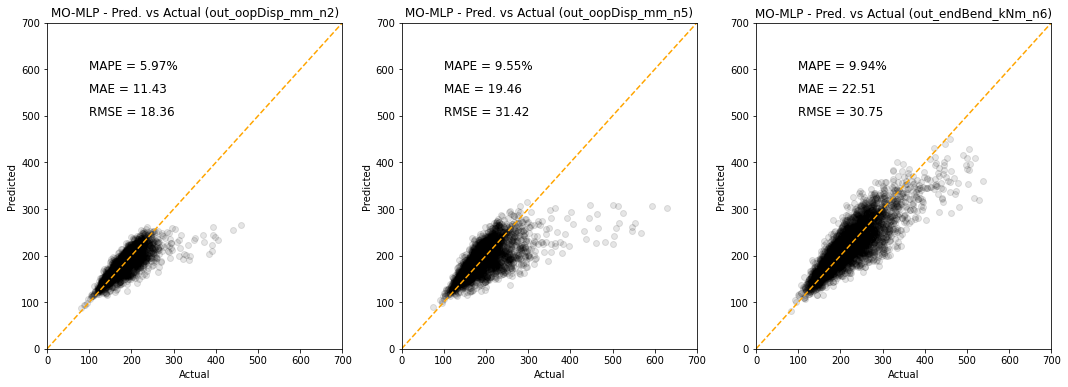

In [308]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

for p in range(3):
    mae = round(globals()[f'mae_momlp_{p}'], 2)
    rmse = round(globals()[f'rmse_momlp_{p}'], 2)
    mape = round(globals()[f'mape_momlp_{p}'], 2)
    ax[p].scatter(y[:, p], yhat[:, p], color = 'black', zorder = 1, alpha=0.1)
    ax[p].plot([0, 700], [0, 700], '--', color = 'orange', zorder = 2)
    ax[p].set(ylabel = 'Predicted', xlabel = 'Actual')
    ax[p].set_title(f'MO-MLP - Pred. vs Actual ({pred_target[p]})')
    ax[p].text(100, 600, f'MAPE = {round(mape, 2)}%', fontsize = 12)
    ax[p].text(100, 550, f'MAE = {round(mae, 2)}', fontsize = 12)
    ax[p].text(100, 500, f'RMSE = {round(rmse, 2)}', fontsize = 12)    
    ax[p].set_ylim(0, 700)
    ax[p].set_xlim(0, 700)
plt.show()

## 2) Random Forest Regression
The main benefit of using regression trees is that these methods are able to find non-linear relationships between the dependent and independent variables whereas the previous method focused on the linear relationships. This is often of benefit when it comes to more complex relationships between variables but can sometimes come at the cost of overfitting and also time and resources.

In [89]:
# Fitting Random Forest Regression to the Training set
from sklearn.ensemble import RandomForestRegressor

In [90]:
regressor = RandomForestRegressor(n_estimators = 50, random_state = 0)    
regressor.fit(X_train.to_numpy(), y_train.to_numpy())

RandomForestRegressor(n_estimators=50, random_state=0)

In [91]:
y_pred = regressor.predict(X_val.to_numpy())

In [92]:
y_bas = df_inp[pred_target].to_numpy()
scaler_m = preprocessing.StandardScaler()
y_scl = scaler_m.fit_transform(y_bas)

In [93]:
# Inverse transform (scaling) to review metrics such as MAE
y = scaler_m.inverse_transform(y_val)
yhat = scaler_m.inverse_transform(y_pred)

mae = metrics.mean_absolute_error(y, yhat)
mse = metrics.mean_squared_error(y, yhat)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y,yhat)

print("Results of sklearn.metrics:")
print("MAE:", round(mae, 2))
print("MSE:", round(mse, 2))
print("RMSE:", round(rmse, 2))
print("R-Squared:", round(r2, 2))

Results of sklearn.metrics:
MAE: 9.2
MSE: 184.53
RMSE: 13.58
R-Squared: 0.92


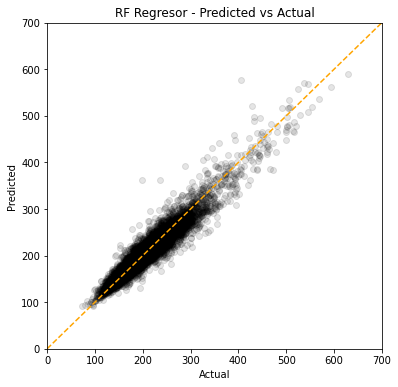

In [94]:
fig, ax = plt.subplots(figsize = (6, 6))
plt.scatter(y, yhat, color = 'black', zorder = 1, alpha=0.1)
plt.plot([0, 700], [0, 700], '--', color = 'orange', zorder = 2)
plt.xlim(0, 700)
plt.ylim(0, 700)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title("RF Regresor - Predicted vs Actual")
plt.show()

In [95]:
df_imp = pd.DataFrame()
df_imp["Para"], df_imp["importance"] = [list(X_test.columns), regressor.feature_importances_]
df_imp.sort_values('importance', ascending=False)

,Para,importance
8,simTime,0.306170
6,baseAmp,0.252526
10,centrFor,0.238558
4,slugVel,0.065144
1,slugLen,0.045132
3,pockLen,0.041875
9,densDiff,0.013146
0,slugDen,0.010927
5,basePer,0.009903
7,basePha,0.009300


## 3) Mulit-layer Perceptron (MLP) - Simple Feed-Forward NN - Multi-output
Class MLPRegressor implements a multi-layer perceptron (MLP) that trains using backpropagation with no activation function in the output layer, which can also be seen as using the identity function as activation function. Therefore, it uses the square error as the loss function, and the output is a set of continuous values.
https://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [295]:
from sklearn import tree
from sklearn import datasets
from sklearn import model_selection
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

In [296]:
pred_target = ['out_oopDisp_mm_n2', 'out_oopDisp_mm_n5', 'out_endBend_kNm_n6']
X_test

,slugDen,slugLen,pockDen,pockLen,slugVel,basePer,baseAmp,basePha,simTime,densDiff,centrFor
case_ref,,,,,,,,,,,
17383,-0.071671,1.181308,1.001272,0.880464,0.631148,-0.189570,0.001677,1.206268,-0.176877,-0.614695,0.262299
16889,-0.327364,-0.704159,0.315490,-0.460427,-2.106824,-0.659019,-0.596952,-0.705865,1.988624,-0.447948,-1.575217
48033,0.316121,-0.809745,1.072490,-0.050154,-1.885777,-1.318244,1.099163,1.881550,1.618125,-0.330649,-1.470461
39158,0.640920,1.322089,0.745604,-1.275969,0.234267,-0.109664,-1.195581,-2.049446,-0.317411,0.121475,0.148337
6552,0.446227,-2.343258,-2.194173,1.300744,-1.051826,-0.309430,2.396193,-0.298901,0.391646,1.588272,-0.693588
...,...,...,...,...,...,...,...,...,...,...,...
2462,3.219113,0.577958,1.006273,1.290737,-2.222372,-1.218361,0.201220,0.428248,3.579213,2.127871,-1.465013
15010,-0.803798,0.316507,-1.140294,0.190005,-0.293232,0.709373,1.198935,-1.137766,0.097803,-0.038620,-0.384670
29597,0.655672,0.014832,0.527346,0.305082,-1.061874,-0.309430,0.999392,-1.346236,0.749369,0.254740,-0.920720


In [297]:
clf = MLPRegressor(random_state=1, max_iter=3000).fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = clf.predict(X_val.to_numpy())

In [298]:
y_bas = df_inp[pred_target].to_numpy()
scaler_m = preprocessing.StandardScaler()
y_scl = scaler_m.fit_transform(y_bas)

In [300]:
# Inverse transform (scaling) to review metrics such as MAE
y = scaler_m.inverse_transform(y_val)
yhat = scaler_m.inverse_transform(y_pred)

for target in range(3):
    y_t = y[:, target]
    yhat_t = yhat[:, target]

    globals()[f'mae_momlp_{target}'] = metrics.mean_absolute_error(y_t, yhat_t)
    globals()[f'mse_momlp_{target}']  = metrics.mean_squared_error(y_t, yhat_t)
    globals()[f'rmse_momlp_{target}'] = np.sqrt(globals()[f'mse_momlp_{target}']) # or mse**(0.5)
    globals()[f'mape_momlp_{target}'] = 100*metrics.mean_absolute_percentage_error(y_t, yhat_t) 
    r2 = metrics.r2_score(y_t, yhat_t)

    print(f'\nTarget {target+1}: Results of sklearn.metrics:')
    print("MAE:", round(globals()[f'mae_momlp_{target}'], 2))
    print("MSE:", round(globals()[f'mse_momlp_{target}'], 2))
    print("RMSE:", round(globals()[f'rmse_momlp_{target}'], 2))
    print("MAPE:", round(globals()[f'mape_momlp_{target}'], 2))
    print("R-Squared:", round(r2, 2))


Target 1: Results of sklearn.metrics:
MAE: 5.1
MSE: 52.76
RMSE: 7.26
MAPE: 2.79
R-Squared: 0.94

Target 2: Results of sklearn.metrics:
MAE: 8.59
MSE: 154.19
RMSE: 12.42
MAPE: 4.57
R-Squared: 0.92

Target 3: Results of sklearn.metrics:
MAE: 13.83
MSE: 328.76
RMSE: 18.13
MAPE: 6.4
R-Squared: 0.9


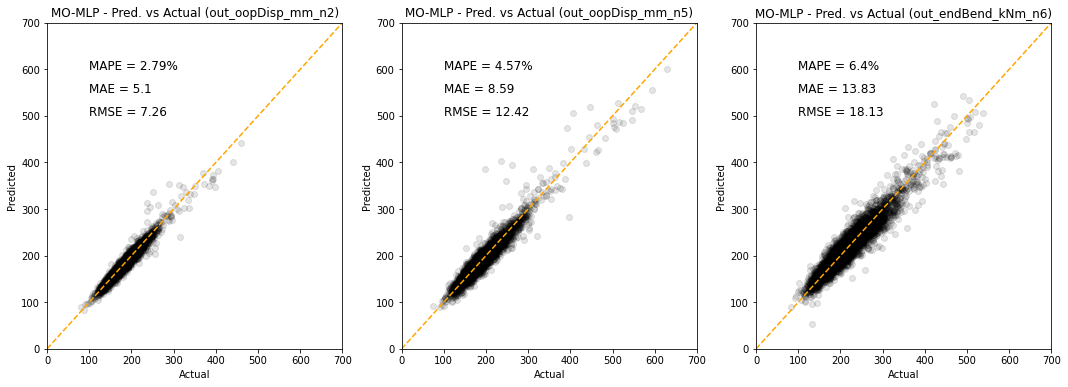

In [303]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

for p in range(3):
    mae = round(globals()[f'mae_momlp_{p}'], 2)
    rmse = round(globals()[f'rmse_momlp_{p}'], 2)
    mape = round(globals()[f'mape_momlp_{p}'], 2)
    ax[p].scatter(y[:, p], yhat[:, p], color = 'black', zorder = 1, alpha=0.1)
    ax[p].plot([0, 700], [0, 700], '--', color = 'orange', zorder = 2)
    ax[p].set(ylabel = 'Predicted', xlabel = 'Actual')
    ax[p].set_title(f'MO-MLP - Pred. vs Actual ({pred_target[p]})')
    ax[p].text(100, 600, f'MAPE = {round(mape, 2)}%', fontsize = 12)
    ax[p].text(100, 550, f'MAE = {round(mae, 2)}', fontsize = 12)
    ax[p].text(100, 500, f'RMSE = {round(rmse, 2)}', fontsize = 12)    
    ax[p].set_ylim(0, 700)
    ax[p].set_xlim(0, 700)
plt.show()